## Way Point Generator
Heavily insipred by the work of FRC team 2168
* [Their code](https://github.com/KHEngineering/SmoothPathPlanner/blob/11059aa2ec314ba20b364aeea3c968aca2672b49/src/usfirst/frc/team2168/robot/FalconPathPlanner.java#L214)

This notebook is created by Sarah Xiang from VRC team 97963A

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib

## Graphing helper functions

In [2]:
def add_line (path) :
    for i in range (0,len(path)):
        plt.plot(path[i][0],path[i][1],'.',color='red',markersize=10)
    
    for i in range(0,len(path)-1):
        plt.plot([path[i][0],path[i+1][0]],[path[i][1],path[i+1][1]],color='b')
    
    plt.axis('scaled')
    # plt.show()
    
def add_complicated_line (path,lineStyle,lineColor,lineLabel) :
    for i in range (0,len(path)):
        plt.plot(path[i][0],path[i][1],'.',color='red',markersize=10)
    
    for i in range(0,len(path)-1):        
        if(i == 0):
            # plt.plot([path[i][0],path[i+1][0]],[path[i][1],path[i+1][1]],color='b')
            plt.plot([path[i][0],path[i+1][0]],[path[i][1],path[i+1][1]],lineStyle,color=lineColor,label=lineLabel)
        else:
            plt.plot([path[i][0],path[i+1][0]],[path[i][1],path[i+1][1]],lineStyle,color=lineColor)
    
    plt.axis('scaled')
    
def highlight_points (points, pointColor):
    for point in points :
        plt.plot(point[0], point[1], '.', color = pointColor, markersize = 10)
        
def draw_circle (x, y, r, circleColor):
    xs = []
    ys = []
    angles = np.arange(0, 2.2*np.pi, 0.5)
    
    for angle in angles :
        xs.append(r*np.cos(angle) + x)
        ys.append(r*np.sin(angle) + y)
    
    plt.plot(xs, ys, '-', color = circleColor)

## Injecting points

In [3]:
# specify num of points for each path
def add_more_points (path,num_of_points):
    new_path = []
    
    for i in range (0,len(path)-1):
        segment_x = (path[i+1][0] - path[i][0])/num_of_points
        segment_y = (path[i+1][1] - path[i][1])/num_of_points
        for j in range (0,num_of_points):
            new_point = [(path[i][0] + j*segment_x),(path[i][1] + j*segment_y)]
            new_path.append(new_point)
    
    new_path.append(path[-1])
    
    return new_path

# specify the distance between adjacent points
def add_more_points2 (path,segment_length):
    new_path = []
    
    for i in range (0,len(path)-1):
        
        distance = np.sqrt((path[i+1][0] - path[i][0])**2 + (path[i+1][1] - path[i][1])**2)
        num_of_points = int(round(distance/segment_length))
        
        if num_of_points == 0:
            new_path.append(path[i])
            
        else:
            segment_x = (path[i+1][0] - path[i][0]) / num_of_points
            segment_y = (path[i+1][1] - path[i][1]) / num_of_points

            for j in range (0,num_of_points):
                new_point = [(path[i][0] + j*segment_x),(path[i][1] + j*segment_y)]
                new_path.append(new_point)
    
    new_path.append(path[-1])
    
    return new_path 

## Smoothing
Original Java code by FRC team 2168.
Link: https://github.com/KHEngineering/SmoothPathPlanner/blob/11059aa2ec314ba20b364aeea3c968aca2672b49/src/usfirst/frc/team2168/robot/FalconPathPlanner.java#L214

In [4]:
# reference value 0.1, 0.3, 0.00001
def smoothing (path,weight_data,weight_smooth,tolerance):
    
    smoothed_path = path.copy()
    change = tolerance
    
    while change >= tolerance :
        change = 0.0

        for i in range (1,len(path)-1):
            
            for j in range (0,len(path[i])):
                aux = smoothed_path[i][j]

                smoothed_path[i][j] += weight_data * (path[i][j] - smoothed_path[i][j]) + weight_smooth * (smoothed_path[i-1][j] + smoothed_path[i+1][j] - (2.0 * smoothed_path[i][j]))
                change += np.abs(aux - smoothed_path[i][j])
                
    return smoothed_path

def sgn (num):
  if num >= 0:
    return 1
  else:
    return -1

def findMinAngle (absTargetAngle, currentHeading) :

  minAngle = absTargetAngle - currentHeading

  if minAngle > 180 or minAngle < -180 :
    minAngle = -1 * sgn(minAngle) * (360 - abs(minAngle))
  
  return minAngle

def autoSmooth (path, maxAngle) :
  currentMax = 0
  param = 0.01
  new_path = path
  firstLoop = True

  counter = 0

  while (currentMax >= maxAngle or firstLoop == True) : # and counter <= 15 :

    param += 0.01
    firstLoop = False

    # counter += 1
    # print('this is the {} iteration'.format(counter))

    new_path = smoothing (path, 0.1, param, 0.1)
    currentMax = 0

    for i in range (1, len(new_path)-2) :
      angle1 = math.atan2(new_path[i][1] - new_path[i-1][1], new_path[i][0] - new_path[i-1][0]) *180/np.pi
      if angle1 < 0 : angle1 += 360
      angle2 = math.atan2(new_path[i+1][1] - new_path[i][1], new_path[i+1][0] - new_path[i][0]) *180/np.pi
      if angle2 < 0 : angle2 += 360

      if abs(findMinAngle(angle2, angle1)) > currentMax :
        currentMax = abs(findMinAngle(angle2, angle1))
  
  return new_path

## Visualizing

In [5]:
# also smooth path and add more points
def path_visualizer (orig_path, fig_size, field_size, segment_length, maxAngle):
    
    path = add_more_points2(orig_path,segment_length)
    path = autoSmooth (path, maxAngle)
    
    field = plt.figure()
    xscale,yscale = fig_size
    path_ax = field.add_axes([0,0,xscale,yscale])
    add_complicated_line(orig_path,'--','grey','original')
    add_complicated_line(path,'--','orange','smoothed')
    
    xMin, yMin, xMax, yMax = field_size
    
    # plot field
    path_ax.plot([xMin,xMax],[yMin,yMin],color='black')
    path_ax.plot([xMin,xMin],[yMin,yMax],color='black')
    path_ax.plot([xMax,xMax],[yMin,yMax],color='black')
    path_ax.plot([xMax,xMin],[yMax,yMax],color='black')
    
    # set grid
    xTicks = np.arange(xMin, xMax+1, 2)
    yTicks = np.arange(yMin, yMax+1, 2)
    
    path_ax.set_xticks(xTicks)
    path_ax.set_yticks(yTicks)
    path_ax.grid(True)
    
    path_ax.set_xlim(xMin-0.25,xMax+0.25)
    path_ax.set_ylim(yMin-0.25,yMax+0.25)
    
    # plot start and end
    path_ax.plot(path[0][0],path[0][1],'.',color='blue',markersize=15,label='start')
    path_ax.plot(path[-1][0],path[-1][1],'.',color='green',markersize=15,label='end')
    path_ax.legend()
    
    return path

# covert to c++ 2d array format
def convert (path, pathName):
    length = 0
    print('double {}[{}][2] = '.format(pathName, len(path)))
    print('{')
    for i in range (0, len(path)):
        length += 1
        print('  {',path[i][0],',', path[i][1],'}, ')
    print('};')
    print('\n')
    print('length = ',length)

## Graph here:

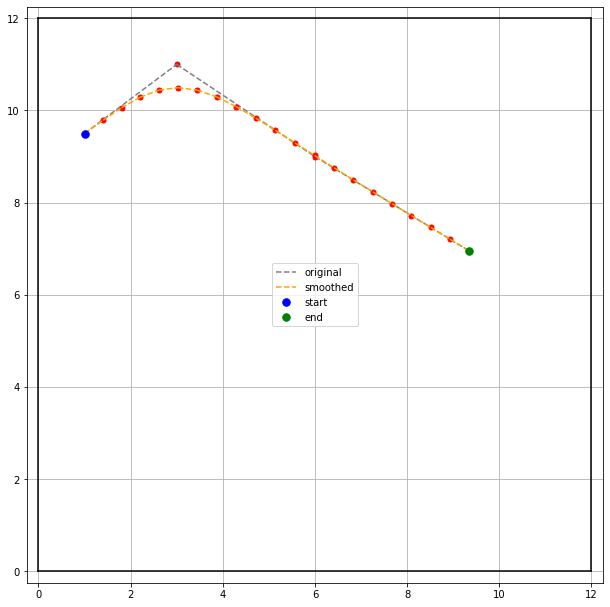

In [6]:
path1 = [[1, 9.5], [3, 11], [6, 9], [9.35, 6.95]]

# path_visualizer (original_path, (figure_size), (figure_x_and_y_limits), length_of_each_line_segment, max_angle_change_between_segments)
path1 = path_visualizer(path1, (2, 2), (0, 0, 12, 12), 0.5, 20)

In [7]:
print(path1)

[[1.0, 9.5], [1.4005979962596538, 9.787741068469028], [1.8020551722735532, 10.057868875531193], [2.2055448478696924, 10.286329759870208], [2.612607942286051, 10.441530571166744], [3.0245752020398156, 10.496165825627882], [3.441821286608739, 10.44243455781583], [3.863567176270255, 10.295838812328805], [4.2883790326726485, 10.084313842952973], [4.714756164245374, 9.835042216129635], [5.141397840234811, 9.567962181125456], [5.567252749422919, 9.295464705634808], [5.9916041708556556, 9.024262860662812], [6.414207487127674, 8.75708613881995], [6.835276317092683, 8.49408363128273], [7.2552585044903894, 8.23419940050469], [7.674594002344124, 7.976211076918656], [8.093596053835594, 7.7192099998358845], [8.512445695481555, 7.4626624410137605], [8.931233051469448, 7.206300731238845], [9.35, 6.95]]


In [9]:
convert(path1, "path1")

double path1[21][2] = 
{
  { 1.0 , 9.5 }, 
  { 1.4005979962596538 , 9.787741068469028 }, 
  { 1.8020551722735532 , 10.057868875531193 }, 
  { 2.2055448478696924 , 10.286329759870208 }, 
  { 2.612607942286051 , 10.441530571166744 }, 
  { 3.0245752020398156 , 10.496165825627882 }, 
  { 3.441821286608739 , 10.44243455781583 }, 
  { 3.863567176270255 , 10.295838812328805 }, 
  { 4.2883790326726485 , 10.084313842952973 }, 
  { 4.714756164245374 , 9.835042216129635 }, 
  { 5.141397840234811 , 9.567962181125456 }, 
  { 5.567252749422919 , 9.295464705634808 }, 
  { 5.9916041708556556 , 9.024262860662812 }, 
  { 6.414207487127674 , 8.75708613881995 }, 
  { 6.835276317092683 , 8.49408363128273 }, 
  { 7.2552585044903894 , 8.23419940050469 }, 
  { 7.674594002344124 , 7.976211076918656 }, 
  { 8.093596053835594 , 7.7192099998358845 }, 
  { 8.512445695481555 , 7.4626624410137605 }, 
  { 8.931233051469448 , 7.206300731238845 }, 
  { 9.35 , 6.95 }, 
};


length =  21
